# Apply vs. np.select no Pandas: uma análise quantitativa de performance

Em ciência de dados, escolhas na implementação de código podem ter impactos na eficiência de esteiras analíticas. Uma dessas escolhas recorrentes é entre utilizar o método .apply() com funções definidas linha a linha ou optar por abordagens vetorizadas como numpy.select(). Embora ambas conduzam ao mesmo resultado lógico, o custo computacional entre elas pode ser distinto, especialmente em grandes volumes de dados.

Neste experimento, foi conduzida uma avaliação sistemática de performance comparando essas duas abordagens, aplicando uma lógica de classificação sobre um conjunto de dados com diferentes comprimentos (N). O experimento consistiu em atribuir uma categoria a cada valor da coluna Value, de acordo com faixas numéricas: valores acima de 1000 seriam classificados como "High", entre 501 e 1000 como "Medium", e até 500 como "Low".

A primeira abordagem utilizou o método .apply(), que aplica uma função Python sobre cada linha do DataFrame. Essa técnica opera sob uma lógica iterativa interna, típica do interpretador Python, que ignora as otimizações vetoriais do NumPy e do Pandas. Como resultado, seu desempenho degrada severamente à medida que o volume de dados cresce.

A segunda abordagem empregou a função numpy.select(), uma técnica vetorizada que avalia todas as condições de uma só vez, em blocos. Essa estratégia se alinha à arquitetura do Pandas, que é construída sobre arrays NumPy otimizados em C. Por isso, oferece ganhos substanciais de performance, sobretudo quando aplicada a datasets com milhões de registros.

Os testes foram realizados em DataFrames com tamanhos variando de centenas a um milhão de linhas. Em cada cenário, o tempo de execução foi medido para ambas as abordagens. Algumas ressalvas do experimento, devido à problemas de memória, não foi possível realizar o test com N maior que 10^6 linhas, e nesta escala de testes, os dois métodos se mostraram com performance estatisticamente semelhantes. Talvez em uma escala maior (N >> 10^6) a hipótese de que o método do Numpy tenha de fato uma performance melhor.

Abaixo o gráfico demonstrando o resultado do teste, e o código do experimento

# Class

In [26]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import warnings

# Gera um DataFrame sintético com uma coluna 'Value' contendo inteiros aleatórios.
# n_rows controla o tamanho; seed garante reprodutibilidade.
def generate_dataframe(n_rows: int = 1_000_000, seed: int = 42) -> pd.DataFrame:
    np.random.seed(seed)
    return pd.DataFrame({'Value': np.random.randint(0, 2000, size=n_rows)})

# Função 1: aplica a classificação via apply(), retornando o DF
def run_apply_example(df: pd.DataFrame) -> pd.DataFrame:

    def classify(value: int) -> str:
        if value > 1000:
            return 'High'
        elif value > 500:
            return 'Medium'
        else:
            return 'Low'

    df = df.copy()
    df['FeatFilter'] = df['Value'].apply(classify)
    return df

# Método baseado em apply(), chamando uma função Python para cada elemento.
# Notoriamente lento em grandes volumes, pois quebra o vetor (loop implícito em Python).
def method_apply(df: pd.DataFrame) -> float:
    # Função de classificação simples, chamada para cada valor.
    def classify(value: int) -> str:
        if value > 1000:
            return 'High'
        elif value > 500:
            return 'Medium'
        else:
            return 'Low'

    start = time.perf_counter()         # Marca o tempo inicial.
    df['FeatFilter'] = df['Value'].apply(classify)  # Aplica função elemento a elemento.
    return time.perf_counter() - start  # Tempo de execução.

# Método vetorizado usando np.select(), muito mais rápido pois evita Python puro.
def method_np_select(df: pd.DataFrame) -> float:
    start = time.perf_counter()

    # Lista de condições Booleanas, avaliadas em vetor.
    conditions = [
        df['Value'] > 1000,
        df['Value'] > 500
    ]

    # Valores atribuídos conforme a ordem das condições.
    choices = ['High', 'Medium']

    # np.select aplica as regras de forma vetorizada.
    df['FeatFilter'] = np.select(conditions, choices, default='Low')

    return time.perf_counter() - start

# Função que roda benchmarks para diferentes tamanhos de DataFrames
# e plota a comparação do tempo do apply() vs np.select().
def benchmark_plot_apply_vs_npselect(
    sizes = [10**1, 10**2, 10**3, 10**4, 10**5, 10**6],
    figsize=(10, 6),
    log_scale=True
):
    apply_times = []
    npselect_times = []

    # Itera sobre cada tamanho, gera os DataFrames e mede os tempos.
    for n in sizes:
        df = generate_dataframe(n)
        apply_times.append(method_apply(df.copy()))         # .copy() para isolar cada teste.
        npselect_times.append(method_np_select(df.copy()))

    plt.figure(figsize=figsize)

    # Curvas dos tempos de execução.
    plt.plot(sizes, apply_times, marker='o', label='apply()')
    plt.plot(sizes, npselect_times, marker='s', label='np.select()', linestyle='--')

    plt.title("Execution Time vs. Data Size")
    plt.xlabel("Number of Rows (N)")
    plt.ylabel("Execution Time (seconds)")

    # Escala log ajuda a visualizar diferenças de ordem de grandeza.
    if log_scale:
        plt.xscale('log')
        plt.yscale('log')

    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Método apply()

O método apply() do Pandas permite aplicar uma função Python sobre cada elemento de uma Series ou sobre cada linha/coluna de um DataFrame. Quando usado em uma coluna, ele funciona como um loop implícito: para cada valor, chama a função e retorna o resultado. É simples e flexível, mas não é vetorizado, portanto é mais lento que operações usando NumPy (np.where, np.select) ou funções nativas do Pandas (map, cut). Use apply() quando a lógica for específica demais para ser vetorizada; evite quando estiver lidando com grandes volumes ou regras simples.

In [45]:
df = pd.DataFrame({'x': [1, 2, 3, 4]})
df

,x
0,1
1,2
2,3
3,4


In [46]:
def quadrado(v):
    return v * v

df['x2'] = df['x'].apply(quadrado)

df

,x,x2
0,1,1
1,2,4
2,3,9
3,4,16


# Método select()

O método np.select() permite criar classificações usando condições vetorizadas, sem loops e sem funções Python. Ele recebe uma lista de condições, uma lista de escolhas e um valor padrão. Tudo é avaliado em modo NumPy, portanto é muito mais rápido que apply().

In [47]:
df = pd.DataFrame({'x': [1, 5, 12, 7]})
df

,x
0,1
1,5
2,12
3,7


In [48]:
#
conditions = [df['x'] > 10, df['x'] > 3]
#
choices = ['alto', 'médio']
#
df['classe'] = np.select(conditions, choices, default='baixo')
#
df

,x,classe
0,1,baixo
1,5,médio
2,12,alto
3,7,médio


# Teste

## Apply

In [49]:
df = generate_dataframe(n_rows = 1_000_000, seed = 42)

In [50]:
df_apply = run_apply_example(df)
df_apply

,Value,FeatFilter
0,1126,High
1,1459,High
2,860,Medium
3,1294,High
4,1130,High
...,...,...
999995,648,Medium
999996,1147,High
999997,1538,High
999998,79,Low


## Select

In [51]:
df_select = run_apply_example(df)
df_select

,Value,FeatFilter
0,1126,High
1,1459,High
2,860,Medium
3,1294,High
4,1130,High
...,...,...
999995,648,Medium
999996,1147,High
999997,1538,High
999998,79,Low


## Teste de performance

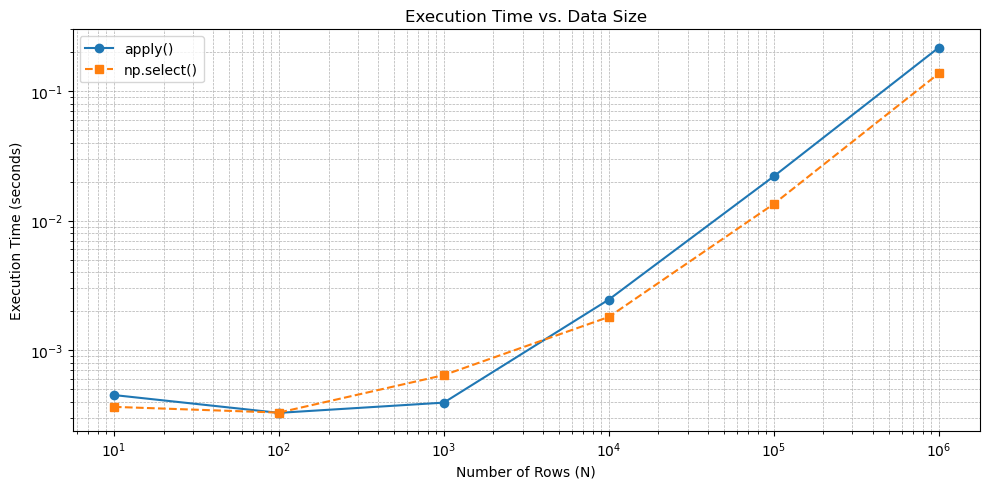

In [16]:
# Executa o benchmark e plota o gráfico
benchmark_plot_apply_vs_npselect(
    sizes=[10**1, 10**2, 10**3, 10**4, 10**5, 10**6],
    figsize=(10, 5),
    log_scale=True
)